# 不動産価格予測コンペ(Nishika)

- [コンペURL](https://www.nishika.com/competitions/20/summary)

## 目的

- 国内の中古マンションの価格推定

### 設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


必要なライブラリーのインストール

In [2]:
!pip install optuna xfeat japanize-matplotlib xgboost >> /dev/null

In [3]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"
%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


zipファイルの解凍

In [4]:
# data.zipファイルの解凍
# 古いdataのディレクトリ削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/　　>> /dev/null

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

# train.zipの解凍
# 古いtrainディレクトリの削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/train/ >> /dev/null

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

outputディレクトリの作成

In [5]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [6]:
import re

import japanize_matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

各種関数の設定

In [7]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

In [8]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [9]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [10]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,1047763,中古マンション等,NaN,1107,北海道,札幌市西区,西野１条,発寒南,10,３ＬＤＫ,65,NaN,NaN,NaN,昭和53年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2020年第２四半期,改装済,NaN,6.991226
1,1003151,中古マンション等,NaN,1101,北海道,札幌市中央区,北１１条西,桑園,5,４ＬＤＫ,80,NaN,NaN,NaN,平成7年,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2018年第２四半期,未改装,NaN,7.278754
2,1004084,中古マンション等,NaN,1101,北海道,札幌市中央区,南１条西,円山公園,6,１Ｒ,20,NaN,NaN,NaN,昭和51年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2012年第１四半期,未改装,NaN,6.361728
3,1056515,中古マンション等,NaN,1107,北海道,札幌市西区,八軒５条西,発寒中央,12,３ＬＤＫ,70,NaN,NaN,NaN,平成6年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種中高層住居専用地域,60.0,200.0,2014年第１四半期,改装済,NaN,7.079181
4,1001193,中古マンション等,NaN,1101,北海道,札幌市中央区,北２条西,西１８丁目,6,３ＬＤＫ,75,NaN,NaN,NaN,平成23年,ＲＣ,NaN,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2019年第３四半期,未改装,NaN,7.505150


In [11]:
# 欠損値の確認
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [12]:
# 提出フォーマットの読み込み
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [13]:
ID = 'ID'
TARGET = '取引価格（総額）_log'

In [14]:
df = pd.concat([train_df, test_df])

In [15]:
# 解析対象外のカラムを指定
rm_cols = []
rm_cols += ['市区町村コード']

# ユニーク数が1以下のカラムを解析対象外のカラムとして指定
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [16]:
# テストデータの目的変数が無いため、np.nan で埋める
test_df[TARGET] = np.nan

# 解析対象外のカラムを削除する
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)

# 解析対象に使用するDataFrameを作成
df = pd.concat([train_df, test_df])

# 取引時点(売買契約/四半期単位)でソートし、indexを振り直す
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [17]:
# 取引時点(売買契約/四半期単位)のユニークを確認
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [18]:
# valid, testデータのインデックスを指定
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [19]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [20]:
# 取引時点(売買契約/四半期単位)を順序尺度に変換
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62


In [21]:
# 都道府県別の取引時点(売買契約/四半期単位)別の平均売買件数を算出
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [22]:
# 都道府県別の取引時点(売買契約/四半期単位)別平均売買件数を追加
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62,7.124361
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62,7.396885
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62,7.161930


In [23]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,大阪府,大阪市旭区,新森,森小路,6.0,１ＬＤＫ,50,1974.0,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,改装済,NaN,7.041393,0,0.0,16
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7.0,３ＬＤＫ,60,1992.0,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,改装済,NaN,7.361728,0,0.0,16
2,13417040,東京都,葛飾区,宝町,お花茶屋,NaN,２ＬＤＫ,60,1993.0,ＲＣ,住宅,NaN,準工業地域,60.0,200.0,改装済,NaN,7.255273,0,0.0,16
3,14267697,神奈川県,横浜市青葉区,あざみ野,あざみ野,NaN,３ＬＤＫ,85,1982.0,NaN,住宅,NaN,NaN,NaN,NaN,NaN,NaN,7.556303,0,0.0,16
4,13386603,東京都,練馬区,豊玉北,練馬,5.0,１Ｋ,20,2005.0,ＲＣ,住宅,NaN,商業地域,80.0,500.0,未改装,NaN,7.278754,0,0.0,16


In [24]:
# 数値データのみを抽出(xfeat)
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [25]:
# カテゴリデータのラベルエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [26]:
# 面積×容積率を計算
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [27]:
encoder = Pipeline([
                    SelectCategorical(exclude_cols=[]),
                    ConcatCombination(drop_origin=True, output_suffix="", r=2),
                    LabelEncoder(output_suffix=""),
                    ])

cal_comb_df = encoder.fit_transform(df)
cal_comb_df.head(2)

,都道府県名市区町村名,都道府県名地区名,都道府県名最寄駅：名称,都道府県名間取り,都道府県名建物の構造,都道府県名用途,都道府県名今後の利用目的,都道府県名都市計画,都道府県名改装,都道府県名取引の事情等,市区町村名地区名,市区町村名最寄駅：名称,市区町村名間取り,市区町村名建物の構造,市区町村名用途,市区町村名今後の利用目的,市区町村名都市計画,市区町村名改装,市区町村名取引の事情等,地区名最寄駅：名称,地区名間取り,地区名建物の構造,地区名用途,地区名今後の利用目的,地区名都市計画,地区名改装,地区名取引の事情等,最寄駅：名称間取り,最寄駅：名称建物の構造,最寄駅：名称用途,最寄駅：名称今後の利用目的,最寄駅：名称都市計画,最寄駅：名称改装,最寄駅：名称取引の事情等,間取り建物の構造,間取り用途,間取り今後の利用目的,間取り都市計画,間取り改装,間取り取引の事情等,建物の構造用途,建物の構造今後の利用目的,建物の構造都市計画,建物の構造改装,建物の構造取引の事情等,用途今後の利用目的,用途都市計画,用途改装,用途取引の事情等,今後の利用目的都市計画,今後の利用目的改装,今後の利用目的取引の事情等,都市計画改装,都市計画取引の事情等,改装取引の事情等
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0


In [28]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(
        df,
        group_key=group_col,
        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
        agg_methods=['count', 'mean', 'min', 'max', 'median', 'std'],
        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_median_最寄駅：距離（分）_grpby_市区町村名,agg_median_面積（㎡）_grpby_市区町村名,agg_median_建ぺい率（％）_grpby_市区町村名,agg_median_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0,8.0,60.0,80.0,200.0,4.327536,16.170642,9.998320,61.473966
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0,10.0,65.0,60.0,200.0,10.878025,23.045336,6.448643,56.522903


In [29]:
feat_df = pd.concat([num_df,le_df,num_comb_df,cal_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 101)


In [30]:
feat_df.dtypes

ID                                 int64
最寄駅：距離（分）                        float64
面積（㎡）                              int64
建築年                              float64
建ぺい率（％）                          float64
                                  ...   
agg_median_容積率（％）_grpby_市区町村名    float64
agg_std_最寄駅：距離（分）_grpby_市区町村名    float64
agg_std_面積（㎡）_grpby_市区町村名        float64
agg_std_建ぺい率（％）_grpby_市区町村名      float64
agg_std_容積率（％）_grpby_市区町村名       float64
Length: 101, dtype: object

モデル構築

In [31]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 101) (24899, 101) (23151, 101)


In [32]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [33]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [34]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [43]:
def objective(trial):

    param = {
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_loguniform(
            "min_child_weight", 1, 40
        ),
        "max_delta_step": trial.suggest_loguniform(
            "max_delta_step", 1e-8, 1.0
        ),
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1000.0),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1000.0),
        "num_boost_round": 3000,
        "tree_method": 'gpu_hist',
    }

    model = xgb.XGBRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

In [45]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=100)

[I 2021-11-30 13:47:55,531] A new study created in memory with name: no-name-f5ee8469-a9ee-4344-94c7-a00742c50439


[13:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:48:12,597] Trial 0 finished with value: 6.796834729834742 and parameters: {'eta': 0.014810344004555135, 'gamma': 1.4656004675652718e-08, 'max_depth': 6, 'min_child_weight': 15.83538918896983, 'max_delta_step': 9.728728830009641e-05, 'subsample': 0.22479664553084766, 'reg_lambda': 198.06286475962398, 'reg_alpha': 760.5307121989588}. Best is trial 0 with value: 6.796834729834742.


[13:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:48:36,144] Trial 1 finished with value: 6.7978075968467655 and parameters: {'eta': 2.2536511574969237e-07, 'gamma': 5.090008568091192e-08, 'max_depth': 7, 'min_child_weight': 33.681648241632445, 'max_delta_step': 1.075439863800637e-08, 'subsample': 0.5121922633857766, 'reg_lambda': 812.6209616521135, 'reg_alpha': 612.5260668293881}. Best is trial 0 with value: 6.796834729834742.


[13:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:48:50,743] Trial 2 finished with value: 6.7956180202209415 and parameters: {'eta': 0.005943503728075847, 'gamma': 2.1627610787257848e-06, 'max_depth': 8, 'min_child_weight': 13.957038399341242, 'max_delta_step': 0.00021895503882644017, 'subsample': 0.14217004760152696, 'reg_lambda': 373.3407600514692, 'reg_alpha': 674.1336150663453}. Best is trial 2 with value: 6.7956180202209415.


[13:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:49:16,585] Trial 3 finished with value: 6.781842313929743 and parameters: {'eta': 3.4250380089316126e-05, 'gamma': 2.965595722907858e-05, 'max_depth': 6, 'min_child_weight': 6.638626701795877, 'max_delta_step': 0.0015965313667163816, 'subsample': 0.6010389534045444, 'reg_lambda': 805.2231968327465, 'reg_alpha': 521.6471523936341}. Best is trial 3 with value: 6.781842313929743.


[13:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:49:48,129] Trial 4 finished with value: 6.7978075968467655 and parameters: {'eta': 0.18586218844499916, 'gamma': 3.5800468653895747e-06, 'max_depth': 3, 'min_child_weight': 3.0320721412222853, 'max_delta_step': 8.163471763379958e-08, 'subsample': 0.8286813263076767, 'reg_lambda': 46.89631938924976, 'reg_alpha': 626.2871483113926}. Best is trial 3 with value: 6.781842313929743.


[13:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:50:17,806] Trial 5 finished with value: 6.7977425681793155 and parameters: {'eta': 0.00024026430110458914, 'gamma': 0.03583405577789633, 'max_depth': 4, 'min_child_weight': 23.589872203126713, 'max_delta_step': 6.504607798014657e-06, 'subsample': 0.7546476915298572, 'reg_lambda': 295.96170687967873, 'reg_alpha': 883.9364795611863}. Best is trial 3 with value: 6.781842313929743.


[13:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:50:32,615] Trial 6 finished with value: 6.427258454486078 and parameters: {'eta': 4.018769547074794e-06, 'gamma': 2.0899080641559773e-07, 'max_depth': 5, 'min_child_weight': 1.4116568076878517, 'max_delta_step': 0.03705486733198003, 'subsample': 0.15115201964256386, 'reg_lambda': 384.1144486921996, 'reg_alpha': 944.2607122388011}. Best is trial 6 with value: 6.427258454486078.


[13:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:51:06,053] Trial 7 finished with value: 6.791796230002588 and parameters: {'eta': 0.7961663152623397, 'gamma': 4.471326429846904e-05, 'max_depth': 7, 'min_child_weight': 2.527647122624913, 'max_delta_step': 0.0006011366210390782, 'subsample': 0.9028317603316274, 'reg_lambda': 534.5579488018151, 'reg_alpha': 590.2013629854229}. Best is trial 6 with value: 6.427258454486078.


[13:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:51:36,285] Trial 8 finished with value: 6.797763787432856 and parameters: {'eta': 2.0618360930258403e-08, 'gamma': 7.202015787920987e-06, 'max_depth': 3, 'min_child_weight': 3.085781095840297, 'max_delta_step': 4.42338250434573e-06, 'subsample': 0.7738302962105958, 'reg_lambda': 39.95920868997727, 'reg_alpha': 429.49217843163837}. Best is trial 6 with value: 6.427258454486078.


[13:51:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:52:06,179] Trial 9 finished with value: 5.703041576071924 and parameters: {'eta': 3.3068536483753737e-06, 'gamma': 0.0012357458041729475, 'max_depth': 5, 'min_child_weight': 1.1723156160023382, 'max_delta_step': 0.10947662395280622, 'subsample': 0.763240587143681, 'reg_lambda': 878.0966427248583, 'reg_alpha': 417.509143839267}. Best is trial 9 with value: 5.703041576071924.


[13:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:52:25,629] Trial 10 finished with value: 3.780203203719059 and parameters: {'eta': 1.1236490834283877e-06, 'gamma': 0.016849989858677448, 'max_depth': 5, 'min_child_weight': 1.0327592094584586, 'max_delta_step': 0.3017686190707031, 'subsample': 0.34363385523431556, 'reg_lambda': 994.8498168822483, 'reg_alpha': 142.95565954325912}. Best is trial 10 with value: 3.780203203719059.


[13:52:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:52:52,476] Trial 11 finished with value: 0.14366349701882683 and parameters: {'eta': 1.16103965950747e-06, 'gamma': 0.01671364940659984, 'max_depth': 5, 'min_child_weight': 1.0093522993477697, 'max_delta_step': 0.8879289296993194, 'subsample': 0.3548381086447221, 'reg_lambda': 998.8178138443747, 'reg_alpha': 121.18048286752872}. Best is trial 11 with value: 0.14366349701882683.


[13:52:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:53:16,075] Trial 12 finished with value: 0.1920863651630575 and parameters: {'eta': 1.861490959615566e-07, 'gamma': 0.5721247573169012, 'max_depth': 4, 'min_child_weight': 1.1797727963023616, 'max_delta_step': 0.7636926808259427, 'subsample': 0.3379258836831506, 'reg_lambda': 990.8983998468714, 'reg_alpha': 20.108456391437898}. Best is trial 11 with value: 0.14366349701882683.


[13:53:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:53:41,270] Trial 13 finished with value: 0.1527681172357925 and parameters: {'eta': 1.7894052808291296e-08, 'gamma': 0.9375637682044548, 'max_depth': 4, 'min_child_weight': 1.9746204516033963, 'max_delta_step': 0.8443869468487031, 'subsample': 0.35388189828538574, 'reg_lambda': 660.4797210901105, 'reg_alpha': 11.678426396714599}. Best is trial 11 with value: 0.14366349701882683.


[13:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:53:52,859] Trial 14 finished with value: 6.659168564006037 and parameters: {'eta': 1.792071943003162e-08, 'gamma': 0.8081385167771233, 'max_depth': 4, 'min_child_weight': 2.180110222913578, 'max_delta_step': 0.013863913917384285, 'subsample': 0.00681525900334079, 'reg_lambda': 623.6553335328663, 'reg_alpha': 241.01469915291614}. Best is trial 11 with value: 0.14366349701882683.


[13:53:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:54:13,806] Trial 15 finished with value: 6.720359049960321 and parameters: {'eta': 6.673349851819802e-05, 'gamma': 0.002932737802027009, 'max_depth': 4, 'min_child_weight': 5.49383481048306, 'max_delta_step': 0.007744854914631624, 'subsample': 0.4044995434740963, 'reg_lambda': 667.0665478572515, 'reg_alpha': 268.37244962576153}. Best is trial 11 with value: 0.14366349701882683.


[13:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:54:40,606] Trial 16 finished with value: 0.5043661528264395 and parameters: {'eta': 1.7445710508045351e-07, 'gamma': 0.05555129283650782, 'max_depth': 3, 'min_child_weight': 5.14912065903488, 'max_delta_step': 0.6394645055490987, 'subsample': 0.5903229792223471, 'reg_lambda': 693.9261111179134, 'reg_alpha': 20.156686785565142}. Best is trial 11 with value: 0.14366349701882683.


[13:54:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:55:02,094] Trial 17 finished with value: 6.724240266009516 and parameters: {'eta': 1.2530888036948038e-08, 'gamma': 0.000532376352833125, 'max_depth': 6, 'min_child_weight': 1.8044794512660995, 'max_delta_step': 0.0073567397192207, 'subsample': 0.4287247544361928, 'reg_lambda': 519.9395701735936, 'reg_alpha': 187.79138027867805}. Best is trial 11 with value: 0.14366349701882683.


[13:55:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:55:19,282] Trial 18 finished with value: 5.649534963294214 and parameters: {'eta': 1.5175077913641802e-05, 'gamma': 0.15128848722537622, 'max_depth': 5, 'min_child_weight': 3.6989869654261742, 'max_delta_step': 0.11482737101091803, 'subsample': 0.25033627584336404, 'reg_lambda': 885.9866407334904, 'reg_alpha': 334.272115716519}. Best is trial 11 with value: 0.14366349701882683.


[13:55:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:55:45,445] Trial 19 finished with value: 6.797703765555567 and parameters: {'eta': 6.483875456850216e-07, 'gamma': 0.006742233908324378, 'max_depth': 4, 'min_child_weight': 1.7891672111172308, 'max_delta_step': 1.0385483458847052e-05, 'subsample': 0.6122936914459136, 'reg_lambda': 742.8553348937814, 'reg_alpha': 125.35867095771529}. Best is trial 11 with value: 0.14366349701882683.


[13:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:56:08,686] Trial 20 finished with value: 6.374763690158075 and parameters: {'eta': 0.0010989847607315274, 'gamma': 0.00024373709888144473, 'max_depth': 7, 'min_child_weight': 8.210120451927747, 'max_delta_step': 0.04230436364872673, 'subsample': 0.4981988064584246, 'reg_lambda': 585.6874014692123, 'reg_alpha': 104.65379212484052}. Best is trial 11 with value: 0.14366349701882683.


[13:56:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:56:27,116] Trial 21 finished with value: 4.952385567351526 and parameters: {'eta': 1.075276427655235e-07, 'gamma': 0.956527444185486, 'max_depth': 4, 'min_child_weight': 1.4190333362826941, 'max_delta_step': 0.1845423337365647, 'subsample': 0.30072766217978786, 'reg_lambda': 988.7729337380721, 'reg_alpha': 1.8494061162423776}. Best is trial 11 with value: 0.14366349701882683.


[13:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:56:53,726] Trial 22 finished with value: 0.14121479408942042 and parameters: {'eta': 6.282098658542615e-08, 'gamma': 0.21785509930701008, 'max_depth': 4, 'min_child_weight': 1.0348796772640763, 'max_delta_step': 0.9080487357675515, 'subsample': 0.3757028383794817, 'reg_lambda': 934.0197931831697, 'reg_alpha': 59.719518730329476}. Best is trial 22 with value: 0.14121479408942042.


[13:56:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:57:23,854] Trial 23 finished with value: 0.13972686655895894 and parameters: {'eta': 9.115306901486635e-08, 'gamma': 0.16178607659607427, 'max_depth': 5, 'min_child_weight': 1.0054135849791008, 'max_delta_step': 0.8892792566255568, 'subsample': 0.44269230829067663, 'reg_lambda': 891.5449548640465, 'reg_alpha': 73.29235705304399}. Best is trial 23 with value: 0.13972686655895894.


[13:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:57:46,441] Trial 24 finished with value: 6.775757931395716 and parameters: {'eta': 7.665735887862023e-06, 'gamma': 0.09284319421680444, 'max_depth': 5, 'min_child_weight': 1.0384555701755789, 'max_delta_step': 0.0022049656551829497, 'subsample': 0.4733721801702822, 'reg_lambda': 891.5234778214524, 'reg_alpha': 323.80191380201813}. Best is trial 23 with value: 0.13972686655895894.


[13:57:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:58:14,159] Trial 25 finished with value: 6.477403126879877 and parameters: {'eta': 1.1725219447744685e-06, 'gamma': 0.01260527611969852, 'max_depth': 6, 'min_child_weight': 1.4588733634215658, 'max_delta_step': 0.0320404076491869, 'subsample': 0.6734712033992366, 'reg_lambda': 915.9679944794692, 'reg_alpha': 92.11072139076435}. Best is trial 23 with value: 0.13972686655895894.


[13:58:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:58:50,081] Trial 26 finished with value: 5.359491132422632 and parameters: {'eta': 6.761516183585544e-08, 'gamma': 0.17181581089058057, 'max_depth': 5, 'min_child_weight': 4.020517494444657, 'max_delta_step': 0.14383159472479914, 'subsample': 0.9985956785078031, 'reg_lambda': 781.9323748735669, 'reg_alpha': 185.39272927299353}. Best is trial 23 with value: 0.13972686655895894.


[13:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:59:05,524] Trial 27 finished with value: 6.7977997886383 and parameters: {'eta': 6.364306254956244e-07, 'gamma': 0.0017650029070853254, 'max_depth': 3, 'min_child_weight': 1.5547207512465417, 'max_delta_step': 7.797251001251751e-07, 'subsample': 0.17752280896296593, 'reg_lambda': 910.3570596271301, 'reg_alpha': 258.15148814203195}. Best is trial 23 with value: 0.13972686655895894.


[13:59:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:59:18,578] Trial 28 finished with value: 4.0514313298122815 and parameters: {'eta': 4.7334544978941064e-08, 'gamma': 0.2204743923620501, 'max_depth': 5, 'min_child_weight': 2.4094686727635435, 'max_delta_step': 0.2746417384067099, 'subsample': 0.07367056571137282, 'reg_lambda': 734.9162036206586, 'reg_alpha': 90.24167991572274}. Best is trial 23 with value: 0.13972686655895894.


[13:59:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 13:59:41,567] Trial 29 finished with value: 0.16043656572883788 and parameters: {'eta': 0.0002741002523826764, 'gamma': 0.027161628344248824, 'max_depth': 6, 'min_child_weight': 11.006370098046201, 'max_delta_step': 0.851240155541869, 'subsample': 0.26327749763189656, 'reg_lambda': 817.3815800922109, 'reg_alpha': 382.5367784662478}. Best is trial 23 with value: 0.13972686655895894.


[13:59:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:00:03,053] Trial 30 finished with value: 6.797182403727716 and parameters: {'eta': 3.685102452294895e-07, 'gamma': 0.004744029276647516, 'max_depth': 5, 'min_child_weight': 1.3238354470192821, 'max_delta_step': 6.251761180265847e-05, 'subsample': 0.42927848594472595, 'reg_lambda': 938.2643343867553, 'reg_alpha': 758.3955417863124}. Best is trial 23 with value: 0.13972686655895894.


[14:00:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:00:28,498] Trial 31 finished with value: 0.15815952684239115 and parameters: {'eta': 3.181831252366501e-08, 'gamma': 0.28627315561728883, 'max_depth': 4, 'min_child_weight': 1.9605008422296712, 'max_delta_step': 0.8268078306829562, 'subsample': 0.36792300421926, 'reg_lambda': 842.9118740559784, 'reg_alpha': 54.036907936538626}. Best is trial 23 with value: 0.13972686655895894.


[14:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:00:52,755] Trial 32 finished with value: 5.962345503493494 and parameters: {'eta': 6.931623972053742e-08, 'gamma': 0.06543337763523625, 'max_depth': 4, 'min_child_weight': 1.102037229302662, 'max_delta_step': 0.08354628386578312, 'subsample': 0.5383388848346904, 'reg_lambda': 458.4992539920636, 'reg_alpha': 176.60558525948795}. Best is trial 23 with value: 0.13972686655895894.


[14:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:01:11,083] Trial 33 finished with value: 3.0965936459802905 and parameters: {'eta': 1.2304404181224804e-08, 'gamma': 0.3673057255388479, 'max_depth': 4, 'min_child_weight': 1.0090961405951042, 'max_delta_step': 0.3701411020792666, 'subsample': 0.2971658572903607, 'reg_lambda': 951.334502889935, 'reg_alpha': 81.482091504299}. Best is trial 23 with value: 0.13972686655895894.


[14:01:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:01:27,239] Trial 34 finished with value: 6.6671565400802555 and parameters: {'eta': 2.457501492757267e-06, 'gamma': 0.9875369445203303, 'max_depth': 6, 'min_child_weight': 1.7320901358816865, 'max_delta_step': 0.013065102777238775, 'subsample': 0.20724851445126874, 'reg_lambda': 763.3284794914442, 'reg_alpha': 212.10962028936152}. Best is trial 23 with value: 0.13972686655895894.


[14:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:01:54,561] Trial 35 finished with value: 0.14551357203336626 and parameters: {'eta': 1.846844463810071e-07, 'gamma': 1.1956641777966073e-08, 'max_depth': 3, 'min_child_weight': 2.664778132337517, 'max_delta_step': 0.939384349352444, 'subsample': 0.4614941449605528, 'reg_lambda': 830.3906380681202, 'reg_alpha': 144.45010374028877}. Best is trial 23 with value: 0.13972686655895894.


[14:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:02:18,951] Trial 36 finished with value: 6.7978075968467655 and parameters: {'eta': 2.6661578488355684e-07, 'gamma': 1.1023706488543045e-08, 'max_depth': 3, 'min_child_weight': 3.1302217407379422, 'max_delta_step': 1.0860112603744412e-08, 'subsample': 0.5438708926524266, 'reg_lambda': 833.0506857461761, 'reg_alpha': 313.06937228375546}. Best is trial 23 with value: 0.13972686655895894.


[14:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:02:46,497] Trial 37 finished with value: 6.7781829463684025 and parameters: {'eta': 1.4308234721128504e-05, 'gamma': 5.86892054676844e-08, 'max_depth': 8, 'min_child_weight': 36.73272145069342, 'max_delta_step': 0.0019624637467870773, 'subsample': 0.6675817020168113, 'reg_lambda': 247.638527361909, 'reg_alpha': 166.14158507526562}. Best is trial 23 with value: 0.13972686655895894.


[14:02:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:03:09,066] Trial 38 finished with value: 6.407319687529749 and parameters: {'eta': 0.008275393092638231, 'gamma': 3.1866395281993643e-07, 'max_depth': 3, 'min_child_weight': 2.5511542815515185, 'max_delta_step': 0.039048776285847124, 'subsample': 0.4727723373369206, 'reg_lambda': 102.30406075831621, 'reg_alpha': 64.02316038912389}. Best is trial 23 with value: 0.13972686655895894.


[14:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:03:30,611] Trial 39 finished with value: 6.796430193110651 and parameters: {'eta': 1.8743074875057114e-06, 'gamma': 1.1574198286541054e-05, 'max_depth': 3, 'min_child_weight': 28.509239183623414, 'max_delta_step': 0.00013773919200111255, 'subsample': 0.43078384422340477, 'reg_lambda': 856.1258199029451, 'reg_alpha': 537.2200939180523}. Best is trial 23 with value: 0.13972686655895894.


[14:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:03:44,278] Trial 40 finished with value: 6.082521818801111 and parameters: {'eta': 0.0661952232830284, 'gamma': 8.283149431519291e-07, 'max_depth': 7, 'min_child_weight': 1.303481042714697, 'max_delta_step': 0.07152862960800241, 'subsample': 0.10062822158778156, 'reg_lambda': 949.3737967265951, 'reg_alpha': 455.96867274051}. Best is trial 23 with value: 0.13972686655895894.


[14:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:04:11,798] Trial 41 finished with value: 0.13465667859647967 and parameters: {'eta': 5.697472500574904e-08, 'gamma': 0.03453791174648078, 'max_depth': 4, 'min_child_weight': 2.0753584002156593, 'max_delta_step': 0.938965833220833, 'subsample': 0.3891641202443451, 'reg_lambda': 692.145468640614, 'reg_alpha': 0.9349815344555203}. Best is trial 41 with value: 0.13465667859647967.


[14:04:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:04:32,905] Trial 42 finished with value: 3.6146075764245538 and parameters: {'eta': 9.436688508075402e-08, 'gamma': 0.00012305326943735665, 'max_depth': 5, 'min_child_weight': 1.510453752904519, 'max_delta_step': 0.3183306613950513, 'subsample': 0.4108564312309972, 'reg_lambda': 791.8412653200362, 'reg_alpha': 149.02532438438928}. Best is trial 41 with value: 0.13465667859647967.


[14:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:04:51,448] Trial 43 finished with value: 3.776057055554415 and parameters: {'eta': 3.4820043608171285e-07, 'gamma': 0.017002955267524468, 'max_depth': 3, 'min_child_weight': 4.001285415822151, 'max_delta_step': 0.30218308773568836, 'subsample': 0.30516698128730785, 'reg_lambda': 946.619233522791, 'reg_alpha': 49.91724557318737}. Best is trial 41 with value: 0.13465667859647967.


[14:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:05:11,441] Trial 44 finished with value: 2.876473297838372 and parameters: {'eta': 4.887510469322409e-08, 'gamma': 0.04786311830528022, 'max_depth': 4, 'min_child_weight': 1.235218290683456, 'max_delta_step': 0.39215684994428807, 'subsample': 0.3642772073415878, 'reg_lambda': 725.9898388385753, 'reg_alpha': 123.72682866382395}. Best is trial 41 with value: 0.13465667859647967.


[14:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:05:42,665] Trial 45 finished with value: 0.14113004582727862 and parameters: {'eta': 6.022266015498845e-07, 'gamma': 0.0008870337223965271, 'max_depth': 5, 'min_child_weight': 2.803257658291175, 'max_delta_step': 0.9033410713822889, 'subsample': 0.4785338375267211, 'reg_lambda': 861.7549605593615, 'reg_alpha': 224.4962850302025}. Best is trial 41 with value: 0.13465667859647967.


[14:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:06:06,934] Trial 46 finished with value: 5.278124712630457 and parameters: {'eta': 7.773749973580134e-06, 'gamma': 0.0005270971320852394, 'max_depth': 5, 'min_child_weight': 2.168123435615055, 'max_delta_step': 0.15196833690481723, 'subsample': 0.5393672224078392, 'reg_lambda': 997.78912290524, 'reg_alpha': 228.79370386263295}. Best is trial 41 with value: 0.13465667859647967.


[14:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:06:27,307] Trial 47 finished with value: 6.585813306494898 and parameters: {'eta': 9.385436751063648e-07, 'gamma': 0.007989712080130617, 'max_depth': 5, 'min_child_weight': 1.629511860110821, 'max_delta_step': 0.021199423054679315, 'subsample': 0.38035506387281015, 'reg_lambda': 450.00111307587594, 'reg_alpha': 39.60233087020376}. Best is trial 41 with value: 0.13465667859647967.


[14:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:06:52,655] Trial 48 finished with value: 6.791619740649408 and parameters: {'eta': 3.1193068267035946e-08, 'gamma': 0.001014421401637676, 'max_depth': 6, 'min_child_weight': 18.571424188721448, 'max_delta_step': 0.0006187844890142503, 'subsample': 0.5812437129567098, 'reg_lambda': 567.4780322333092, 'reg_alpha': 996.3491138657373}. Best is trial 41 with value: 0.13465667859647967.


[14:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:07:09,421] Trial 49 finished with value: 6.153791092559046 and parameters: {'eta': 1.3245900282926957e-07, 'gamma': 0.029075160447507818, 'max_depth': 5, 'min_child_weight': 7.33867940501333, 'max_delta_step': 0.06440168601418822, 'subsample': 0.23474182678406658, 'reg_lambda': 880.9985276691705, 'reg_alpha': 72.40481718613995}. Best is trial 41 with value: 0.13465667859647967.


[14:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:07:32,692] Trial 50 finished with value: 1.239163905956316 and parameters: {'eta': 4.2617162597258586e-07, 'gamma': 0.08901195361431437, 'max_depth': 4, 'min_child_weight': 1.1328537537083552, 'max_delta_step': 0.5560867173132743, 'subsample': 0.5005047190261488, 'reg_lambda': 688.2884803377638, 'reg_alpha': 682.7719646670467}. Best is trial 41 with value: 0.13465667859647967.


[14:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:07:57,375] Trial 51 finished with value: 0.14008638775063326 and parameters: {'eta': 1.9808916978923674e-07, 'gamma': 2.9566902923745037e-05, 'max_depth': 4, 'min_child_weight': 2.810943841475346, 'max_delta_step': 0.9468837578636208, 'subsample': 0.3185718764720791, 'reg_lambda': 817.8554173552708, 'reg_alpha': 133.40916760812348}. Best is trial 41 with value: 0.13465667859647967.


[14:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:08:22,497] Trial 52 finished with value: 0.13847991451532915 and parameters: {'eta': 2.6227438265238916e-08, 'gamma': 3.244807441325668e-05, 'max_depth': 4, 'min_child_weight': 3.308023345759429, 'max_delta_step': 0.9913760644377347, 'subsample': 0.3199595042363148, 'reg_lambda': 864.746457262434, 'reg_alpha': 288.94093018982744}. Best is trial 41 with value: 0.13465667859647967.


[14:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:08:41,495] Trial 53 finished with value: 5.087192915602869 and parameters: {'eta': 2.5911088968638054e-08, 'gamma': 3.9388055998520345e-05, 'max_depth': 4, 'min_child_weight': 4.6745410513335175, 'max_delta_step': 0.17106131915500078, 'subsample': 0.3245840312118081, 'reg_lambda': 789.399134501188, 'reg_alpha': 283.16382518480015}. Best is trial 41 with value: 0.13465667859647967.


[14:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:08:59,163] Trial 54 finished with value: 2.4607709905485073 and parameters: {'eta': 1.220249602472581e-08, 'gamma': 8.101414760738579e-06, 'max_depth': 4, 'min_child_weight': 2.876917485472415, 'max_delta_step': 0.433733046975312, 'subsample': 0.27140314796156456, 'reg_lambda': 863.1202863244639, 'reg_alpha': 366.7674682367683}. Best is trial 41 with value: 0.13465667859647967.


[14:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:09:26,738] Trial 55 finished with value: 0.13565534318413722 and parameters: {'eta': 1.0435703046350883e-07, 'gamma': 1.6245310889999526e-05, 'max_depth': 4, 'min_child_weight': 3.300572033202948, 'max_delta_step': 0.9931490905982426, 'subsample': 0.3948202029665292, 'reg_lambda': 623.4914395128638, 'reg_alpha': 212.8269498305749}. Best is trial 41 with value: 0.13465667859647967.


[14:09:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:09:42,622] Trial 56 finished with value: 6.751783274337 and parameters: {'eta': 1.0283634613105124e-07, 'gamma': 2.2806349684096473e-05, 'max_depth': 4, 'min_child_weight': 3.504339036933127, 'max_delta_step': 0.004602429283734951, 'subsample': 0.19730820797493748, 'reg_lambda': 588.1312015662363, 'reg_alpha': 282.9973987782136}. Best is trial 41 with value: 0.13465667859647967.


[14:09:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:10:04,661] Trial 57 finished with value: 4.746993683501429 and parameters: {'eta': 1.9366410327220204e-07, 'gamma': 7.825102702397421e-05, 'max_depth': 5, 'min_child_weight': 3.2828338052083472, 'max_delta_step': 0.20508115485892545, 'subsample': 0.45285807941823863, 'reg_lambda': 704.7146563090905, 'reg_alpha': 219.5623238525293}. Best is trial 41 with value: 0.13465667859647967.


[14:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:10:25,366] Trial 58 finished with value: 5.950640343352503 and parameters: {'eta': 3.019069910374754e-08, 'gamma': 4.095876207321488e-06, 'max_depth': 4, 'min_child_weight': 4.676199858892327, 'max_delta_step': 0.08471679043156628, 'subsample': 0.39540253290888444, 'reg_lambda': 644.823404556017, 'reg_alpha': 201.81554048457733}. Best is trial 41 with value: 0.13465667859647967.


[14:10:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:10:44,323] Trial 59 finished with value: 2.239366634155252 and parameters: {'eta': 6.489135437507193e-07, 'gamma': 1.7697304745194317e-05, 'max_depth': 4, 'min_child_weight': 6.028101065184532, 'max_delta_step': 0.4558778675551642, 'subsample': 0.3232736872890579, 'reg_lambda': 760.4262737058554, 'reg_alpha': 9.153962999858322}. Best is trial 41 with value: 0.13465667859647967.


[14:10:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:11:02,206] Trial 60 finished with value: 6.797803841754145 and parameters: {'eta': 1.922742544499351e-06, 'gamma': 1.960117745195823e-06, 'max_depth': 5, 'min_child_weight': 4.290493157610516, 'max_delta_step': 3.784524298798833e-07, 'subsample': 0.2800429232561861, 'reg_lambda': 658.7618538112087, 'reg_alpha': 475.89328554968336}. Best is trial 41 with value: 0.13465667859647967.


[14:11:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:11:29,220] Trial 61 finished with value: 0.1387020645104579 and parameters: {'eta': 5.8351760727910715e-08, 'gamma': 8.459731020337882e-05, 'max_depth': 4, 'min_child_weight': 2.2727124753658483, 'max_delta_step': 0.9376536052756237, 'subsample': 0.3844451543031222, 'reg_lambda': 904.9493028174795, 'reg_alpha': 104.29421065001429}. Best is trial 41 with value: 0.13465667859647967.


[14:11:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:11:48,553] Trial 62 finished with value: 1.999430627343494 and parameters: {'eta': 1.0808910771647515e-08, 'gamma': 7.900606027131963e-05, 'max_depth': 4, 'min_child_weight': 2.283400580704332, 'max_delta_step': 0.4798796706834648, 'subsample': 0.3381855261231842, 'reg_lambda': 815.5726322034666, 'reg_alpha': 116.69489235288796}. Best is trial 41 with value: 0.13465667859647967.


[14:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:12:09,487] Trial 63 finished with value: 4.733993433638758 and parameters: {'eta': 4.2510007865175864e-08, 'gamma': 0.0001772399636491492, 'max_depth': 4, 'min_child_weight': 2.883131147012699, 'max_delta_step': 0.20638160796652788, 'subsample': 0.40467440350792827, 'reg_lambda': 619.0033979433981, 'reg_alpha': 246.9022211096386}. Best is trial 41 with value: 0.13465667859647967.


[14:12:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:12:40,891] Trial 64 finished with value: 0.13448150462766645 and parameters: {'eta': 1.0081401309504588e-07, 'gamma': 0.0003994341637707551, 'max_depth': 4, 'min_child_weight': 2.0197504802459965, 'max_delta_step': 0.9796411628739546, 'subsample': 0.5067956480062098, 'reg_lambda': 902.5478241295833, 'reg_alpha': 154.907048681467}. Best is trial 64 with value: 0.13448150462766645.


[14:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:13:02,721] Trial 65 finished with value: 5.587581776305384 and parameters: {'eta': 0.0014797548045147307, 'gamma': 4.553473201701675e-05, 'max_depth': 4, 'min_child_weight': 1.9172287985717764, 'max_delta_step': 0.12102271337673562, 'subsample': 0.4435478417840156, 'reg_lambda': 899.5328343911567, 'reg_alpha': 153.61883903394312}. Best is trial 64 with value: 0.13448150462766645.


[14:13:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:13:29,556] Trial 66 finished with value: 1.5575231352472583 and parameters: {'eta': 2.105386658314195e-08, 'gamma': 0.00037707498028395967, 'max_depth': 3, 'min_child_weight': 2.160787723027153, 'max_delta_step': 0.5241168008797059, 'subsample': 0.6394306543553663, 'reg_lambda': 965.968874567643, 'reg_alpha': 107.75002634900427}. Best is trial 64 with value: 0.13448150462766645.


[14:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:14:02,002] Trial 67 finished with value: 0.13186006524219804 and parameters: {'eta': 8.779927497864026e-08, 'gamma': 1.8444775924457108e-06, 'max_depth': 4, 'min_child_weight': 2.408450895153826, 'max_delta_step': 0.9833272090063138, 'subsample': 0.5254923068254501, 'reg_lambda': 909.4150667446426, 'reg_alpha': 31.885083015384325}. Best is trial 67 with value: 0.13186006524219804.


[14:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:14:25,710] Trial 68 finished with value: 4.1131267677838625 and parameters: {'eta': 9.056238098907115e-08, 'gamma': 2.398604457767098e-06, 'max_depth': 4, 'min_child_weight': 3.598837689490966, 'max_delta_step': 0.26847080987663874, 'subsample': 0.5182021508268999, 'reg_lambda': 372.78101107198023, 'reg_alpha': 28.564658709928437}. Best is trial 67 with value: 0.13186006524219804.


[14:14:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:14:54,888] Trial 69 finished with value: 6.7975371705734196 and parameters: {'eta': 1.88182663375279e-08, 'gamma': 1.1077894454169748e-06, 'max_depth': 3, 'min_child_weight': 2.398283074782972, 'max_delta_step': 2.7041727797249412e-05, 'subsample': 0.7329962705496484, 'reg_lambda': 921.7081435592258, 'reg_alpha': 86.49080941438464}. Best is trial 67 with value: 0.13186006524219804.


[14:14:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:15:19,634] Trial 70 finished with value: 6.25989022128219 and parameters: {'eta': 6.951803237327699e-08, 'gamma': 6.691921422196327e-06, 'max_depth': 4, 'min_child_weight': 2.0488518424658664, 'max_delta_step': 0.05379176992701701, 'subsample': 0.5584382285801098, 'reg_lambda': 971.9152081739801, 'reg_alpha': 183.2434507373765}. Best is trial 67 with value: 0.13186006524219804.


[14:15:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:15:47,595] Trial 71 finished with value: 0.1362735771768701 and parameters: {'eta': 1.5337510646712938e-07, 'gamma': 5.067631677018686e-05, 'max_depth': 4, 'min_child_weight': 1.7481633319556604, 'max_delta_step': 0.9418934959643552, 'subsample': 0.41395397689467633, 'reg_lambda': 896.1797242089766, 'reg_alpha': 40.60582090575198}. Best is trial 67 with value: 0.13186006524219804.


[14:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:16:11,134] Trial 72 finished with value: 1.5277543436921175 and parameters: {'eta': 1.4100632886141407e-07, 'gamma': 1.2461982416795626e-05, 'max_depth': 4, 'min_child_weight': 1.7072522026512793, 'max_delta_step': 0.5271012385479352, 'subsample': 0.5118905147141747, 'reg_lambda': 903.5361740029825, 'reg_alpha': 27.023783212877888}. Best is trial 67 with value: 0.13186006524219804.


[14:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:16:39,921] Trial 73 finished with value: 0.1324853426613672 and parameters: {'eta': 4.1615931576122146e-08, 'gamma': 0.0002555621798536543, 'max_depth': 4, 'min_child_weight': 1.9834526203335676, 'max_delta_step': 0.9749887817927211, 'subsample': 0.4240214505456263, 'reg_lambda': 886.7799425658841, 'reg_alpha': 8.533958559770142}. Best is trial 67 with value: 0.13186006524219804.


[14:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:17:00,810] Trial 74 finished with value: 4.489436291381067 and parameters: {'eta': 4.454276689431357e-08, 'gamma': 0.000249465196624037, 'max_depth': 4, 'min_child_weight': 1.947904114269932, 'max_delta_step': 0.23083743563498735, 'subsample': 0.40235664087942985, 'reg_lambda': 862.2061653508713, 'reg_alpha': 12.334442186509214}. Best is trial 67 with value: 0.13186006524219804.


[14:17:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:17:20,546] Trial 75 finished with value: 5.610626004859156 and parameters: {'eta': 2.5050829929042283e-07, 'gamma': 5.5832559220081094e-05, 'max_depth': 4, 'min_child_weight': 2.5567985025232494, 'max_delta_step': 0.11871820488741534, 'subsample': 0.3551256085354134, 'reg_lambda': 492.3770055774414, 'reg_alpha': 2.1440318894444585}. Best is trial 67 with value: 0.13186006524219804.


[14:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:17:43,622] Trial 76 finished with value: 3.2952893283115063 and parameters: {'eta': 2.0227065821889824e-08, 'gamma': 0.0018549195603291264, 'max_depth': 3, 'min_child_weight': 3.275868126610636, 'max_delta_step': 0.35026819284069555, 'subsample': 0.49243991883696536, 'reg_lambda': 767.4662630839555, 'reg_alpha': 60.605679093250274}. Best is trial 67 with value: 0.13186006524219804.


[14:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:18:08,847] Trial 77 finished with value: 0.9796729405709772 and parameters: {'eta': 5.049872716620115e-08, 'gamma': 0.00012541804289980995, 'max_depth': 4, 'min_child_weight': 1.7967667285076259, 'max_delta_step': 0.5824802976926475, 'subsample': 0.5759816837090508, 'reg_lambda': 931.8899234399663, 'reg_alpha': 106.38414892008038}. Best is trial 67 with value: 0.13186006524219804.


[14:18:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:18:37,895] Trial 78 finished with value: 0.13262949991662396 and parameters: {'eta': 3.890920203267251e-07, 'gamma': 0.00026813372359703216, 'max_depth': 4, 'min_child_weight': 2.3293349763551454, 'max_delta_step': 0.9811129796904942, 'subsample': 0.43096036281275085, 'reg_lambda': 844.2387344700471, 'reg_alpha': 43.91049957259381}. Best is trial 67 with value: 0.13186006524219804.


[14:18:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:18:59,078] Trial 79 finished with value: 4.404344938918299 and parameters: {'eta': 1.240714942452037e-07, 'gamma': 0.0002737320008727525, 'max_depth': 4, 'min_child_weight': 1.4210125904325779, 'max_delta_step': 0.23934660159784468, 'subsample': 0.4163863053122972, 'reg_lambda': 734.365992922334, 'reg_alpha': 34.71990904921975}. Best is trial 67 with value: 0.13186006524219804.


[14:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:19:21,228] Trial 80 finished with value: 6.463986717387384 and parameters: {'eta': 7.541620062981152e-05, 'gamma': 0.0005379824313407998, 'max_depth': 3, 'min_child_weight': 1.5534927436460912, 'max_delta_step': 0.033382074145099756, 'subsample': 0.4561300674967259, 'reg_lambda': 875.5166481504222, 'reg_alpha': 40.4670946858588}. Best is trial 67 with value: 0.13186006524219804.


[14:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:19:43,056] Trial 81 finished with value: 0.3960129365340352 and parameters: {'eta': 3.6612648787156125e-07, 'gamma': 0.00015354477090469257, 'max_depth': 4, 'min_child_weight': 2.503853695978537, 'max_delta_step': 0.6599319332646495, 'subsample': 0.3687068817966998, 'reg_lambda': 836.7467764962885, 'reg_alpha': 94.08513584284228}. Best is trial 67 with value: 0.13186006524219804.


[14:19:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:20:09,270] Trial 82 finished with value: 0.8938434672126376 and parameters: {'eta': 6.255705049922201e-08, 'gamma': 7.827421822745054e-05, 'max_depth': 4, 'min_child_weight': 2.3234973789952567, 'max_delta_step': 0.5914320343182531, 'subsample': 0.6134440261102205, 'reg_lambda': 913.8282701802717, 'reg_alpha': 166.61903485509617}. Best is trial 67 with value: 0.13186006524219804.


[14:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:20:36,546] Trial 83 finished with value: 0.1342052267886736 and parameters: {'eta': 3.739401821924067e-08, 'gamma': 4.805942222826215e-07, 'max_depth': 4, 'min_child_weight': 2.1088310121529563, 'max_delta_step': 0.9614756084562542, 'subsample': 0.3796449864887978, 'reg_lambda': 967.8244151316189, 'reg_alpha': 0.11857661971725975}. Best is trial 67 with value: 0.13186006524219804.


[14:20:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:20:58,172] Trial 84 finished with value: 3.9563662287102628 and parameters: {'eta': 1.542331313070072e-08, 'gamma': 2.529091317546595e-07, 'max_depth': 4, 'min_child_weight': 1.867187830714671, 'max_delta_step': 0.2841495497539158, 'subsample': 0.4355041302219642, 'reg_lambda': 959.8896271114323, 'reg_alpha': 0.506959871096555}. Best is trial 67 with value: 0.13186006524219804.


[14:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:21:20,977] Trial 85 finished with value: 5.567610644026941 and parameters: {'eta': 2.8735050091054005e-08, 'gamma': 1.3830162308441448e-07, 'max_depth': 4, 'min_child_weight': 1.6720387375277277, 'max_delta_step': 0.1230197966757651, 'subsample': 0.4811073443975046, 'reg_lambda': 982.5127825319386, 'reg_alpha': 59.46334331576746}. Best is trial 67 with value: 0.13186006524219804.


[14:21:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:21:53,144] Trial 86 finished with value: 0.131764447948424 and parameters: {'eta': 2.835254700987108e-07, 'gamma': 6.829593086827738e-07, 'max_depth': 4, 'min_child_weight': 2.1056039953035586, 'max_delta_step': 0.9834500351354836, 'subsample': 0.523210240155696, 'reg_lambda': 789.508505949254, 'reg_alpha': 73.50327099577405}. Best is trial 86 with value: 0.131764447948424.


[14:21:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:22:16,639] Trial 87 finished with value: 2.7268491491289963 and parameters: {'eta': 4.685198711911204e-07, 'gamma': 9.409804359129921e-07, 'max_depth': 3, 'min_child_weight': 2.095007756170887, 'max_delta_step': 0.4071209620038893, 'subsample': 0.5094084074937355, 'reg_lambda': 803.5024985042857, 'reg_alpha': 73.29979005945505}. Best is trial 86 with value: 0.131764447948424.


[14:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:22:41,074] Trial 88 finished with value: 5.073147200270838 and parameters: {'eta': 3.056555858220869e-07, 'gamma': 8.967499763734272e-08, 'max_depth': 8, 'min_child_weight': 1.3260702293128057, 'max_delta_step': 0.17246606755978605, 'subsample': 0.5462521629633185, 'reg_lambda': 706.6216727592936, 'reg_alpha': 876.192271526329}. Best is trial 86 with value: 0.131764447948424.


[14:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:23:04,330] Trial 89 finished with value: 0.5571908201320424 and parameters: {'eta': 1.069014244992549e-06, 'gamma': 5.478758785897123e-07, 'max_depth': 4, 'min_child_weight': 2.67494196800425, 'max_delta_step': 0.6312431658816757, 'subsample': 0.4607545642338236, 'reg_lambda': 843.8769952596588, 'reg_alpha': 32.34657996853784}. Best is trial 86 with value: 0.131764447948424.


[14:23:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:23:28,369] Trial 90 finished with value: 5.924893282576746 and parameters: {'eta': 4.03039093926448e-06, 'gamma': 5.810155952728335e-07, 'max_depth': 4, 'min_child_weight': 2.0429206272895284, 'max_delta_step': 0.08729133346698983, 'subsample': 0.530907046896951, 'reg_lambda': 752.8762601658887, 'reg_alpha': 131.08929762417125}. Best is trial 86 with value: 0.131764447948424.


[14:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:23:56,399] Trial 91 finished with value: 0.14049588440858404 and parameters: {'eta': 1.7217336346757194e-07, 'gamma': 1.5045023733568615e-06, 'max_depth': 4, 'min_child_weight': 2.951674324231777, 'max_delta_step': 0.9044955389579767, 'subsample': 0.42207093248640243, 'reg_lambda': 884.1961571806966, 'reg_alpha': 47.804901892809475}. Best is trial 86 with value: 0.131764447948424.


[14:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:24:23,993] Trial 92 finished with value: 0.13430348293903185 and parameters: {'eta': 8.941556265965143e-08, 'gamma': 3.6821753251365928e-06, 'max_depth': 4, 'min_child_weight': 1.8383573242342832, 'max_delta_step': 0.9775288119847003, 'subsample': 0.39027547692016207, 'reg_lambda': 782.8365340661164, 'reg_alpha': 82.6400336774181}. Best is trial 86 with value: 0.131764447948424.


[14:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:24:43,525] Trial 93 finished with value: 3.3053971288333965 and parameters: {'eta': 8.346233856617648e-08, 'gamma': 3.839022083630359e-06, 'max_depth': 4, 'min_child_weight': 1.6216841098470587, 'max_delta_step': 0.34925699643937735, 'subsample': 0.34635437924386164, 'reg_lambda': 773.6822824475123, 'reg_alpha': 75.79250370779916}. Best is trial 86 with value: 0.131764447948424.


[14:24:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:25:05,183] Trial 94 finished with value: 0.47491669725311936 and parameters: {'eta': 1.316409291863778e-07, 'gamma': 4.04876277101747e-07, 'max_depth': 4, 'min_child_weight': 1.8780895556261694, 'max_delta_step': 0.6441374317317518, 'subsample': 0.38052128907955624, 'reg_lambda': 815.4221537290287, 'reg_alpha': 42.387907500814194}. Best is trial 86 with value: 0.131764447948424.


[14:25:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:25:28,109] Trial 95 finished with value: 3.1819871824680432 and parameters: {'eta': 2.518644085723096e-07, 'gamma': 4.779381965259887e-06, 'max_depth': 4, 'min_child_weight': 2.195332003657795, 'max_delta_step': 0.3616002069391329, 'subsample': 0.48761451256656424, 'reg_lambda': 676.19128132408, 'reg_alpha': 87.61424483151504}. Best is trial 86 with value: 0.131764447948424.


[14:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:25:50,026] Trial 96 finished with value: 6.792286060973352 and parameters: {'eta': 8.210878357689486e-07, 'gamma': 1.4649323437150575e-05, 'max_depth': 4, 'min_child_weight': 10.870423136409627, 'max_delta_step': 0.0005521562178715881, 'subsample': 0.4361113667746455, 'reg_lambda': 725.8600636514399, 'reg_alpha': 0.3664344685706453}. Best is trial 86 with value: 0.131764447948424.


[14:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:26:15,042] Trial 97 finished with value: 6.797787331267542 and parameters: {'eta': 3.977219727266495e-08, 'gamma': 2.9873526908148877e-06, 'max_depth': 5, 'min_child_weight': 1.7561589040678558, 'max_delta_step': 2.1100225698613196e-06, 'subsample': 0.5684528250180026, 'reg_lambda': 792.6623387671381, 'reg_alpha': 148.06089397968975}. Best is trial 86 with value: 0.131764447948424.


[14:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:26:41,056] Trial 98 finished with value: 4.846151255294031 and parameters: {'eta': 9.7602605203906e-08, 'gamma': 8.822717988772651e-06, 'max_depth': 4, 'min_child_weight': 1.5006581399977095, 'max_delta_step': 0.19516550247309997, 'subsample': 0.6071915863566807, 'reg_lambda': 847.6983578108693, 'reg_alpha': 22.911877101829532}. Best is trial 86 with value: 0.131764447948424.


[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-30 14:27:06,878] Trial 99 finished with value: 0.1417690469058135 and parameters: {'eta': 5.569662298535839e-07, 'gamma': 1.9499153141167445e-06, 'max_depth': 3, 'min_child_weight': 2.4274318225848757, 'max_delta_step': 0.9711545223404849, 'subsample': 0.3979106090976161, 'reg_lambda': 927.214111846873, 'reg_alpha': 123.65794607682736}. Best is trial 86 with value: 0.131764447948424.


CPU times: user 38min 58s, sys: 24.6 s, total: 39min 22s
Wall time: 39min 11s


In [49]:
best_params = study.best_params
best_params["random_state"] = RANDOM_STATE
best_params["tree_method"] = "gpu_hist"
best_params["num_boost_round"] = 3000
best_params

{'eta': 2.835254700987108e-07,
 'gamma': 6.829593086827738e-07,
 'max_delta_step': 0.9834500351354836,
 'max_depth': 4,
 'min_child_weight': 2.1056039953035586,
 'num_boost_round': 3000,
 'random_state': 10,
 'reg_alpha': 73.50327099577405,
 'reg_lambda': 789.508505949254,
 'subsample': 0.523210240155696,
 'tree_method': 'gpu_hist'}

In [50]:
# チューニングしたハイパーパラメーターをフィット
optimised_model = xgb.XGBRegressor(**(best_params))

optimised_model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

[14:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eta=2.835254700987108e-07, gamma=6.829593086827738e-07,
             max_delta_step=0.9834500351354836, max_depth=4,
             min_child_weight=2.1056039953035586, num_boost_round=3000,
             random_state=10, reg_alpha=73.50327099577405,
             reg_lambda=789.508505949254, subsample=0.523210240155696,
             tree_method='gpu_hist')

In [51]:
val_pred = optimised_model.predict(val_x)
score = mean_absolute_error(val_y, val_pred)
print(f'score: {score:.4f}')

score: 0.1322


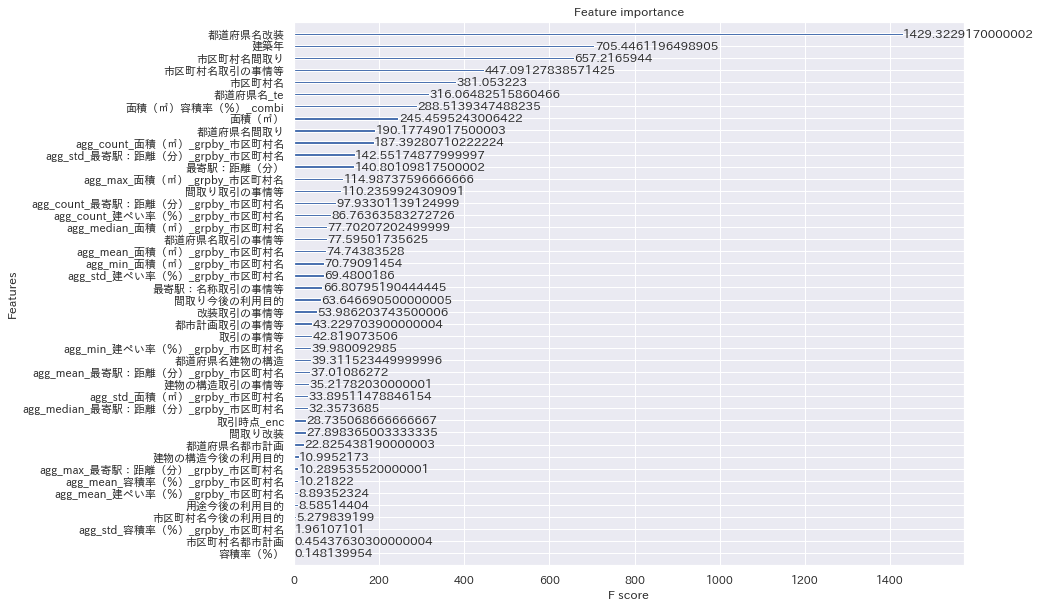

In [63]:
_, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(optimised_model,
                    ax=ax,
                    importance_type='gain',
                    )
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [59]:
# XGBoost推論
y_pred = optimised_model.predict(test_x)

In [60]:
test_df[TARGET] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [62]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))